In [1]:
import os, sys, re

from pathlib import Path

import pandas as pd 
from natsort import natsorted

import seaborn as sns

/Volumes/volume2/2025/MC-Temporary/RvH-temp/Sarc_Examples/bad/MC25DF5-6a-6b-8_D06_s55_w4_scalars.xlsx
/Volumes/volume2/2025/MC-Temporary/RvH-temp/Sarc_Examples/bad/SP25DC9-10-11_D10_s8_w4_scalars.xlsx
/Volumes/volume2/2025/MC-Temporary/RvH-temp/Sarc_Examples/bad/SP25DC9-10-11_E05_s37_w4_scalars.xlsx
/Volumes/volume2/2025/MC-Temporary/RvH-temp/Sarc_Examples/bad/SP25DC9-10-11_E05_s43_w4_scalars.xlsx
/Volumes/volume2/2025/MC-Temporary/RvH-temp/Sarc_Examples/bad/SP25DC9-10-11_E05_s45_w4_scalars.xlsx
/Volumes/volume2/2025/MC-Temporary/RvH-temp/Sarc_Examples/bad/SP25DC9-10-11_E05_s55_w4_scalars.xlsx
--- Provided Data Head ---
  class  pixelsize  n_stack  cell_mask_area  cell_mask_area_ratio  \
0  good     0.1699        1   118546.237084              0.979132   
0  good     0.1699        1   120879.678734              0.998405   
0  good     0.1699        1    59423.712516               0.49081   
0  good     0.1699        1    58704.602475               0.48487   
0  good     0.1699        1

/Users/oliver.hendy/miniconda3/envs/hbbenv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


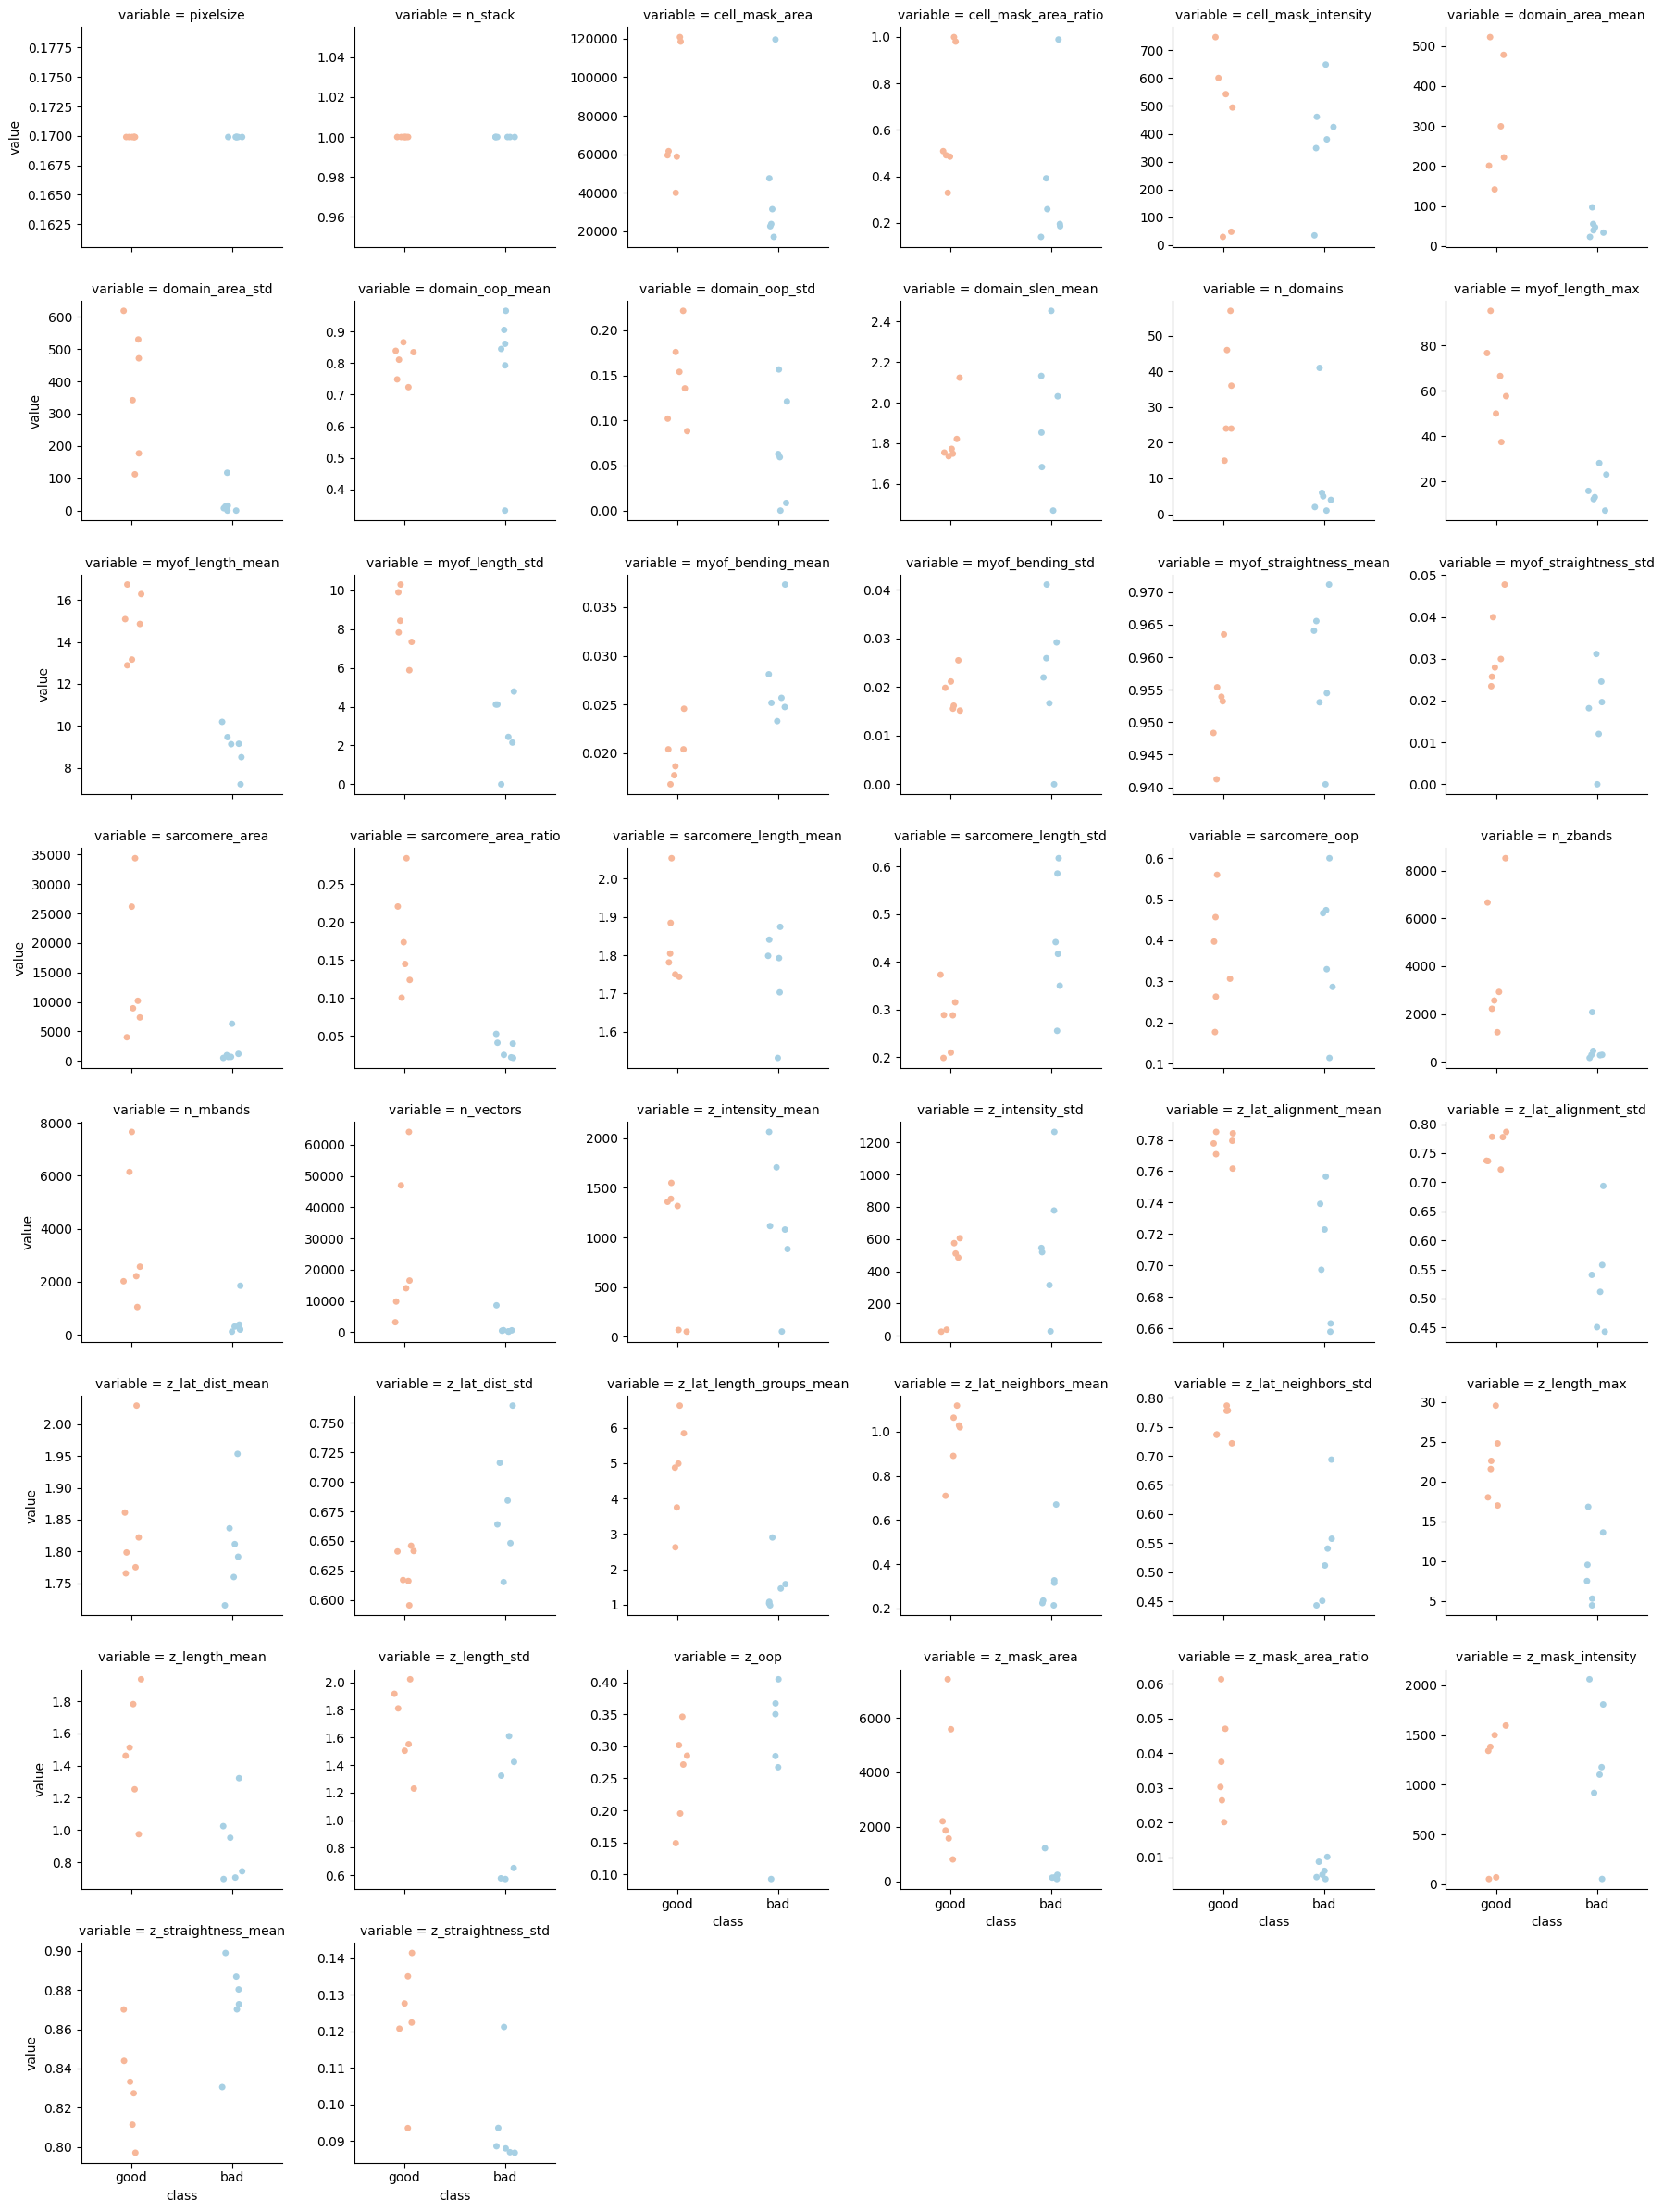

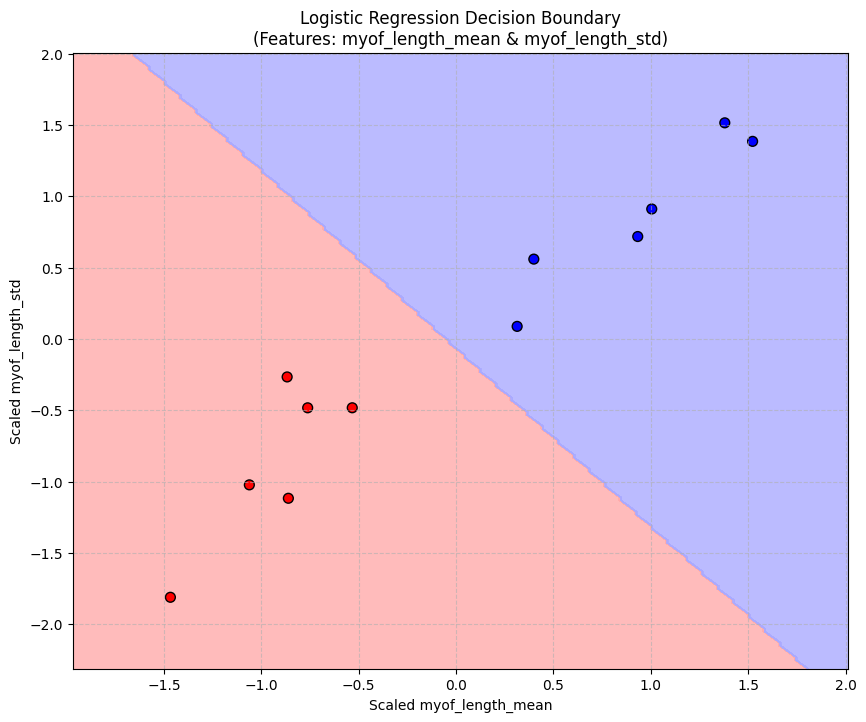

array([ 0.        , -0.07844734, -0.07844734,  0.19611791,  0.18213878,
        0.1637441 , -0.0121489 ,  0.04299928, -0.03267535,  0.03192496,
        0.24725425,  0.25868336,  0.25348454, -0.20938498, -0.0749554 ,
       -0.05805516,  0.0638072 ,  0.11405875,  0.22029941,  0.11073591,
       -0.10069748, -0.03043587,  0.11524959,  0.11622077,  0.1061716 ,
        0.12752411,  0.01342182,  0.1546004 ,  0.24003176,  0.08955099,
       -0.22265233,  0.19222279,  0.22713002,  0.24003176,  0.15325592,
        0.09747134,  0.10606879, -0.14859223,  0.12096276,  0.22837917,
        0.13469488, -0.06876253,  0.14542486])

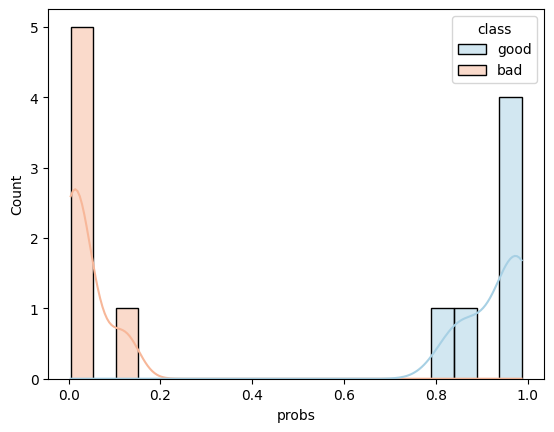

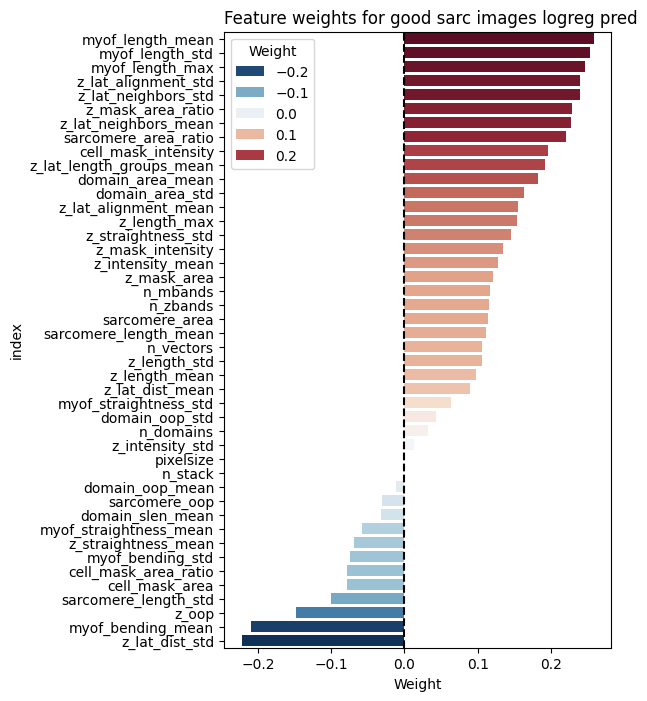

In [2]:
sarcomere_data = Path('/Volumes/volume2/2025/MC-Temporary/RvH-temp/Sarc_Examples')
good_data = natsorted(list((sarcomere_data/'good').iterdir()))
good_data = [x for x in good_data if 'DS_Store' not in x.name ]
good_data = [x for x in good_data if 'xlsx'  in x.name ]
good_sarc_features = pd.concat([pd.read_excel(file,index_col=0).T for file in good_data])
good_sarc_features['class'] = 'good'
good_sarc_features
bad_data = natsorted(list((sarcomere_data/'bad').iterdir()))
bad_data = [x for x in bad_data if 'DS_Store' not in x.name and r'~' not in x.name ]
bad_data = [x for x in bad_data if 'xlsx'  in x.name ]
bad_data


bad_sarc_features = pd.DataFrame()

for file in bad_data:
    print(file)
    f=  pd.read_excel(file,index_col=0).T
    bad_sarc_features = pd.concat([bad_sarc_features,f])
bad_sarc_features['class'] = 'bad'
bad_sarc_features
compare_df = pd.concat([good_sarc_features,bad_sarc_features])
compare_df
compare_df = compare_df.convert_dtypes()
numeric_cols = list(compare_df.dtypes.index[(compare_df.dtypes == 'Float64') | (compare_df.dtypes == 'Int64')])
numeric_cols
subset_df = compare_df.loc[:,['class'] + numeric_cols]
subset_df = subset_df.drop(columns=['frametime','timestamps','time','channel'])
plotdf = subset_df.melt(id_vars = 'class')

import matplotlib.pyplot as plt

g = sns.FacetGrid(plotdf, col='variable',col_wrap=6,sharey=False)
g.map_dataframe(sns.stripplot,x = 'class',y='value',hue='class',palette='RdBu')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.colors import ListedColormap
def run_logistic_regression_analysis(df):
    """
    This function takes a DataFrame, performs a logistic regression classification workflow
    on unscaled data, including model training, weight inspection,
    and visualization of the decision boundary. The DataFrame is expected to have
    a 'class' column with 'good' and 'bad' values, and other numeric feature columns.
    """
    # 1. --- Initial Data Inspection ---
    print("--- Provided Data Head ---")
    print(df.head())
    print("\n--- Class Distribution ---")
    print(df['class'].value_counts())

    # 2. --- Data Preparation ---
    # Map target variable to numerical format
    df['class'] = df['class'].map({'good': 1, 'bad': 0})

    # Separate features (X) and target (y)
    X = df.drop('class', axis=1)
    y = df['class']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # 3. --- Build and Train the Model Pipeline ---
    # Create a pipeline that first scales the data and then fits the logistic regression model.
    # This is the correct way to handle scaling to prevent data leakage from the test set.
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(random_state=42))
    ])

    # Train the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # 4. --- Evaluate the Model ---
    y_pred = pipeline.predict(X_test)
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred))

    print("\n--- Confusion Matrix ---")
    print(confusion_matrix(y_test, y_pred))

    # 5. --- Display Model Weights (Coefficients) ---
    # Access the logistic regression model and its coefficients from the pipeline
    model = pipeline.named_steps['logreg']
    coefficients = model.coef_[0]
    intercept = model.intercept_[0]

    # Create a DataFrame for better visualization of weights
    weights = pd.DataFrame(
        coefficients,
        index=X.columns,
        columns=['Weight']
    ).sort_values('Weight', ascending=False)

    print("\n--- Model Weights ---")
    print(weights)
    print(f"\nIntercept: {intercept:.4f}")

    # 6. --- Plot Decision Boundary ---
    # For visualization, we can only plot in 2D. We will use the two features
    # with the largest absolute weights.
    most_important_features = weights.abs().sort_values('Weight', ascending=False).index[:2]
    print(f"\nPlotting decision boundary for the two most important features: {most_important_features[0]} and {most_important_features[1]}")

    # Create a new pipeline with only the two selected features
    X_vis = df[most_important_features]
    y_vis = df['class']
    
    pipeline_vis = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(random_state=42))
    ])
    pipeline_vis.fit(X_vis, y_vis)

    # Create a mesh grid
    scaler_vis = pipeline_vis.named_steps['scaler']
    X_scaled_vis = scaler_vis.transform(X_vis)

    h = .02  # step size in the mesh
    x_min, x_max = X_scaled_vis[:, 0].min() - .5, X_scaled_vis[:, 0].max() + .5
    y_min, y_max = X_scaled_vis[:, 1].min() - .5, X_scaled_vis[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict on the mesh grid to get the decision boundary
    Z = pipeline_vis.predict(scaler_vis.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 8))
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF']) # Colors for background
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])   # Colors for points

    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)

    # Plot the training points
    plt.scatter(X_scaled_vis[:, 0], X_scaled_vis[:, 1], c=y_vis, cmap=cmap_bold,
                edgecolor='k', s=50)
    
    plt.title(f'Logistic Regression Decision Boundary\n(Features: {most_important_features[0]} & {most_important_features[1]})')
    plt.xlabel(f'Scaled {most_important_features[0]}')
    plt.ylabel(f'Scaled {most_important_features[1]}')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    
    return pipeline
train_df = subset_df.__deepcopy__()
pipeline = run_logistic_regression_analysis(train_df)
pipeline
probs = pipeline.predict_proba(subset_df.iloc[:,1:])[:,1]
predict_df = subset_df.__deepcopy__()
predict_df['probs'] = probs

sns.histplot(predict_df,x='probs',hue='class',bins=20,kde=True,palette='RdBu_r')

model = pipeline.named_steps['logreg']
weights = pd.DataFrame(
        model.coef_[0],
        index=subset_df.columns[1:],
        columns=['Weight']
    ).sort_values('Weight', ascending=False)
weights= weights.reset_index(drop=False)
weights = weights
weights

fig, ax = plt.subplots(figsize=(5, 8))
sns.barplot(weights,x='Weight',y='index',hue='Weight',palette = 'RdBu_r')
plt.axvline(x=0,linestyle='--',color='black')
plt.title('Feature weights for good sarc images logreg pred',loc ='left')

model.coef_[0][1:]


## Predict New

In [3]:
predict_df = pd.read_excel('/Users/oliver.hendy/Downloads/quant_summary_slices.xlsx')

In [4]:
predict_df

,batch_id,tif_file,tif_name,tif_dir,axes,pixelsize,frametime,shape_orig,shape,n_stack,...,z_lat_neighbors_std,z_length_max,z_length_mean,z_length_std,z_oop,z_mask_area,z_mask_area_ratio,z_mask_intensity,z_straightness_mean,z_straightness_std
0,batch_1,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,MC25DF5-6a-6b-8_F02_s14_w4.TIF,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,YX,0.1699,NaN,2048.0,2048.0,1,...,0.749311,15.2910,1.592837,1.658415,0.211103,4582.017231,0.038043,1224.981359,0.818481,0.127707
1,batch_1,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,MC25DF5-6a-6b-8_F02_s15_w4.TIF,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,YX,0.1699,NaN,2048.0,2048.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,batch_1,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,MC25DF5-6a-6b-8_F02_s16_w4.TIF,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,YX,0.1699,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,batch_1,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,MC25DF5-6a-6b-8_F02_s17_w4.TIF,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,YX,0.1699,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,batch_1,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,MC25DF5-6a-6b-8_F02_s18_w4.TIF,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,YX,0.1699,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,batch_1,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,MC25DF5-6a-6b-8_F02_s14_w4.TIF,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,TXY,0.1699,NaN,5.0,5.0,5,...,0.743296,20.3880,1.561642,1.619416,0.122762,4097.703316,0.034091,1234.201013,0.821511,0.124536
6,batch_1,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,MC25DF5-6a-6b-8_F02_s15_w4.TIF,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,TXY,0.1699,NaN,2048.0,2048.0,5,...,0.732604,12.0629,1.435881,1.350973,0.292266,3400.069586,0.028269,1289.388130,0.832816,0.117382
7,batch_1,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,MC25DF5-6a-6b-8_F02_s16_w4.TIF,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,TXY,0.1699,NaN,2048.0,2048.0,5,...,0.744123,15.1211,1.482639,1.490274,0.080564,3555.022328,0.029606,1316.048540,0.827980,0.119448
8,batch_1,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,MC25DF5-6a-6b-8_F02_s17_w4.TIF,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,TXY,0.1699,NaN,NaN,NaN,5,...,0.739670,17.3298,1.492781,1.719503,0.350488,3382.663382,0.028521,1152.268157,0.838791,0.116842
9,batch_1,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,MC25DF5-6a-6b-8_F02_s18_w4.TIF,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,TXY,0.1699,NaN,NaN,NaN,5,...,0.728903,15.4609,1.609347,1.596353,0.169493,4861.988662,0.040911,1395.009630,0.820916,0.124075


In [5]:
def run_sarc_pred(sarc_features):
    sarc_features =sarc_features.reset_index(drop=True)
    sarc_features= sarc_features.loc[~pd.isna(sarc_features['domain_area_mean']),:]
    sarc_features= sarc_features.loc[~pd.isna(sarc_features['z_intensity_mean']),:]
    sarc_features = sarc_features.drop(columns=['frametime','timestamps','time','channel'])

    predict_df = sarc_features.loc[:,[x for x in train_df.columns if 'class' not in x]]
    sarc_features['class'] = pipeline.predict(predict_df)
    return sarc_features
predict_df = run_sarc_pred(predict_df)


In [6]:
predict_df['well'] = [x[-3] for x in predict_df['tif_name'].str.split('_')]
predict_df

,batch_id,tif_file,tif_name,tif_dir,axes,pixelsize,shape_orig,shape,n_stack,size,...,z_length_mean,z_length_std,z_oop,z_mask_area,z_mask_area_ratio,z_mask_intensity,z_straightness_mean,z_straightness_std,class,well
0,batch_1,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,MC25DF5-6a-6b-8_F02_s14_w4.TIF,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,YX,0.1699,2048.0,2048.0,1,2048.0,...,1.592837,1.658415,0.211103,4582.017231,0.038043,1224.981359,0.818481,0.127707,1,F02
5,batch_1,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,MC25DF5-6a-6b-8_F02_s14_w4.TIF,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,TXY,0.1699,5.0,5.0,5,2048.0,...,1.561642,1.619416,0.122762,4097.703316,0.034091,1234.201013,0.821511,0.124536,1,F02
6,batch_1,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,MC25DF5-6a-6b-8_F02_s15_w4.TIF,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,TXY,0.1699,2048.0,2048.0,5,2048.0,...,1.435881,1.350973,0.292266,3400.069586,0.028269,1289.388130,0.832816,0.117382,1,F02
7,batch_1,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,MC25DF5-6a-6b-8_F02_s16_w4.TIF,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,TXY,0.1699,2048.0,2048.0,5,NaN,...,1.482639,1.490274,0.080564,3555.022328,0.029606,1316.048540,0.827980,0.119448,1,F02
8,batch_1,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,MC25DF5-6a-6b-8_F02_s17_w4.TIF,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,TXY,0.1699,NaN,NaN,5,NaN,...,1.492781,1.719503,0.350488,3382.663382,0.028521,1152.268157,0.838791,0.116842,1,F02
9,batch_1,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,MC25DF5-6a-6b-8_F02_s18_w4.TIF,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,TXY,0.1699,NaN,NaN,5,NaN,...,1.609347,1.596353,0.169493,4861.988662,0.040911,1395.009630,0.820916,0.124075,1,F02
10,batch_2,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,MC25DF5-6a-6b-8_F02_s19_w4.TIF,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,TXY,0.1699,5.0,5.0,5,2048.0,...,1.439987,1.455352,0.220620,3576.354309,0.031705,1010.471440,0.834075,0.110967,1,F02
11,batch_2,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,MC25DF5-6a-6b-8_F02_s20_w4.TIF,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,TXY,0.1699,2048.0,2048.0,5,2048.0,...,1.728483,1.701468,0.179639,4698.693644,0.041676,947.173527,0.822538,0.120612,1,F02
12,batch_2,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,MC25DF5-6a-6b-8_F02_s21_w4.TIF,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,TXY,0.1699,2048.0,2048.0,5,NaN,...,1.585971,1.583695,0.252341,5461.737752,0.045294,1406.362819,0.820246,0.121045,1,F02
13,batch_2,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,MC25DF5-6a-6b-8_F02_s22_w4.TIF,/Users/lokesh.pimpale/Desktop/work_dir/sarcome...,TXY,0.1699,NaN,NaN,5,NaN,...,1.595769,1.673699,0.165639,4047.014602,0.033505,1240.131355,0.816940,0.125004,1,F02


In [7]:
platemap_df = pd.read_excel('/Users/oliver.hendy/Desktop/tmp_platemap.xlsx')
platemap_df


,well,Rep,Line,Treatment
0,D01,1,GCaMP,MM
1,D02,1,GCaMP,BayK
2,D03,1,GCaMP,D46
3,D05,2,H8,MM
4,D06,2,H8,BayK
5,D07,2,H8,D46
6,E01,1,H8,MM
7,E02,1,H8,BayK
8,E03,1,H8,D46
9,E05,2,E1,MM


In [8]:
predict_df =predict_df.merge(platemap_df,on='well',how='left')

In [9]:
for required_col in ['Condition','Treatment']:
    if required_col not in predict_df.columns:
        predict_df[required_col] = 'control'

### Plot

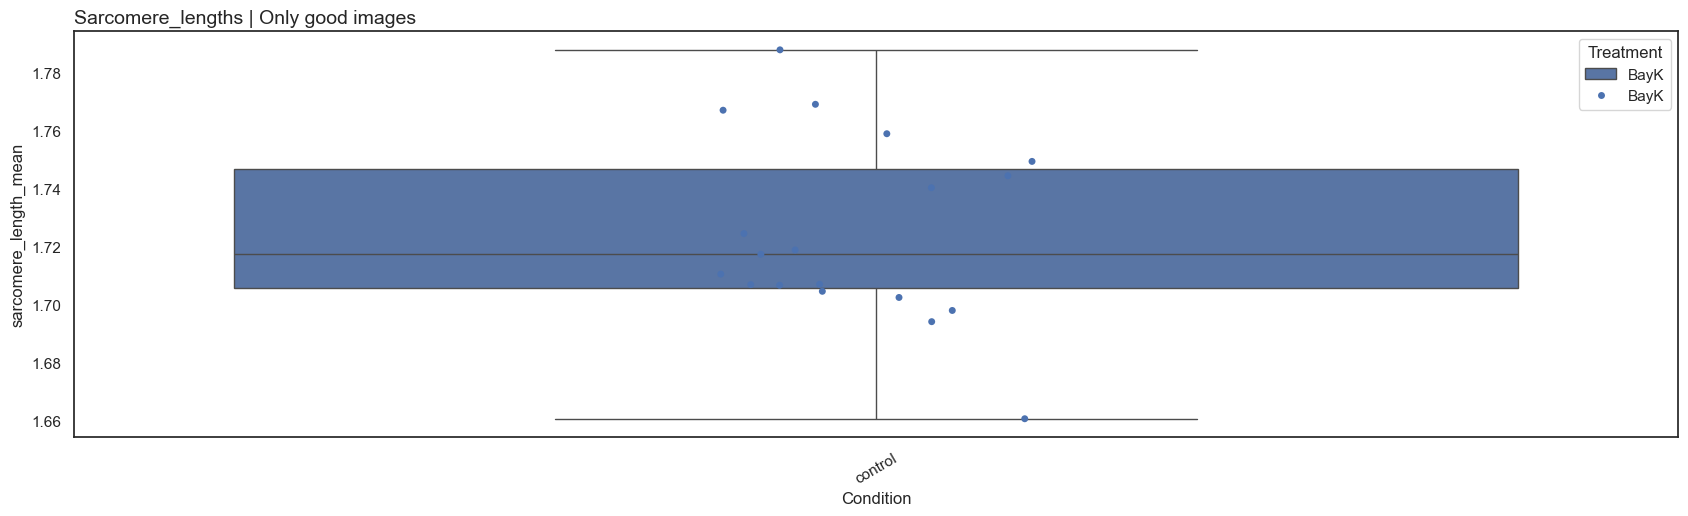

In [10]:
plotdf = predict_df.loc[predict_df['class'] == 1,:]
sns.set_theme(rc={'figure.figsize':(20.7,5.27)},style='white')
ax = sns.boxplot(plotdf,x='Condition',y='sarcomere_length_mean',hue='Treatment')
sns.stripplot(data=plotdf, x="Condition", y="sarcomere_length_mean",hue='Treatment',
              ax=ax,dodge=True)
plt.xticks(rotation=30)
plt.title('Sarcomere_lengths | Only good images ',loc='left',size=14)
plt.show()